# InGaN-Si Tandem Solar Cell

## Introduction
We study about two solar cells InGaN and Si connected in series stacked on top of each other as in the figure below. For InGaN, the bandgap between conduction and valence band can be varied by tweaking the In:Ga fraction. Also, we can change the widths of individual region, so as to optimise the efficiency of the whole cell. References [A], [B], [C] and [D] build analytical models for the same and calculate the optimum efficiency. [A] however, considers the absoprtion coefficient and provides a detailed model, so we shall use it. [B] however reports realistic values taking into account other losses as certain percentage of theoretical efficiency, however, we have omitted them as our objective is to maximise efficiency and not to exactly measure it

<img src="TandemCell.png">

Hence, we have 5 design parameters. We shall develop an analytical model of the cell and then using a meta heuristic tenchinque called Particle Swarm Optimisation, obtain the design parameters for maximum efficiency. For incident photon flux, we use AM 1.5 global spectrum from ASTM G-173-03 Standard.

The contents of this notebook are as follows:

1. [Incident Photon Flux](#Photons)
2. [Analytical Model](#Analytical)
3. [Particle Swarm optimisation](#PSO)
4. [Challenges](#Challenges)
5. [Use of concentrators](#Concentrators)
6. [References](#References)

In [1]:
#Importing the libraries
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import *

## <a name="Photons"></a> Incident Photon Flux

The file 'astmg173.xls' contains the data of incident spectrum. We store the data as $I_0(\lambda)$ i.e. Number of photons per unit area per unit time at a given wavelength $\lambda$

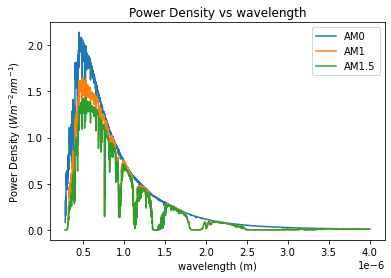

In [2]:
df = pd.read_excel('astmg173.xls')
X=1
λs = df.values[:, 0][1:]*1e-9    #Wavelengths in meters
E1 = df.values[:, 1][1:]         #Power for AM0 per unit area per wavelength
E2 = df.values[:, 2][1:]         #Power for AM1 per unit area per wavelength
E3 = X*df.values[:, 3][1:]         #Power for AM1.5 per unit area per wavelength

plt.plot(λs, E1)
plt.plot(λs, E2)
plt.plot(λs, E3)
plt.ylabel("Power Density ($W m^{-2} nm^{-1}$)")
plt.xlabel("wavelength (m)")
plt.legend(["AM0", "AM1", "AM1.5"])
plt.title("Power Density vs wavelength")
plt.show()

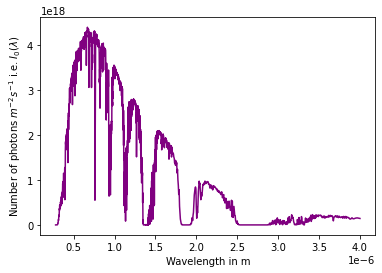

In [3]:
I0 = {}   #Dictionary tyoe variable I0
I = []
for i in range(len(λs)):
    
    λ = λs[i]     #For a particular wavelength λ
    e = h*c/λ     #Energy of one photon at that λ
    n = E3[i]/e   #Number of photons/area/time=Power at that λ/energy of one photon
    I0[λ] = n     #Store in I0
    I.append(n)   #This is just for plotting
    
plt.plot(λs, I, color='purple')
plt.xlabel('Wavelength in m')
plt.ylabel('Number of photons $m^{-2} s^{-1}$ i.e. $I_0(λ)$')
plt.show()

Lets compute the total power per unit area over the entire spectrum by intergrating the above curve of Power density vs wavelength by using trapezoidal integration

In [4]:
def computeArea(Ls, E1, Eg):
    
    #Compute area using trapezoidal integration
    #area between two consecutive data points will be sum of a rectangle and one right triangle
    
    S = 0

    for i in range(0, len(E1)-1):
        
        #the coordinates
        y1 = E1[i]      
        y2 = E1[i+1]
        x1 = Ls[i]*1e9
        x2 = Ls[i+1]*1e9

         
        h1 = abs(x2-x1)      #height of trapezoid
        l1 = min(y1, y2)     #Take the smaller rectangle
        
        E = h*c/x1/eV*1e9    #Energy in eV at a particular wavlength
        
        l2 = abs(y1-y2)      #height of triangle
        
        if E > Eg:
            
            #If the Energy at this λ > Eg, only then consider it as input Power
            S += l1*h1    #Area of rectangle
            S += l2*h1/2  #Area of Smaller rectangle
        
    
    return S

s = computeArea(λs, E3, 1.1)
print("The Power in AM1.5 is "+str(s)+ ' Watt per meter squared')

The Power in AM1.5 is 718.0808177476997 Watt per meter squared


## <a name="Analytical"></a> Analytical Model

The analytical model is based on derivations in [A]

#### Terminologies

* $e$ -> electron charge
* $h$ -> Plank's constant
* $D_h, D_e$ -> Diffusion constants of minority holes, electrons respectively
* $J$ -> current density
* $J_{sc}$ -> short circuit current density
* $J_0$ -> reverse saturation current density
* $k_B$ -> Boltzman's constant
* $\alpha(\lambda)$ -> absorption coefficient of a cell at a given wavelength
* $E_g$ -> Bandgap
* $L_h, L_e$ -> Minority carrier diffusion length
* $M_C, M_V$ -> number of equivalent minima in conduction and valence band respectively
* $m_h^*, m_e^*$ -> Effective mass of hole, electron respectively
* $\mu_e, \mu_h$ -> Mobility of electron, hole respectively
* $N_A, N_D$ -> Doping density of p, n layer of cell
* $N_C, N_V$ -> Density of states in conduction, valence band
* $n_i$ -> i=Intrinsic carrier concentration
* $T$ -> Temperature, assumed constant
* $\tau$ -> Minority Carrier lifetime
* $x_p, x_n$ -> Thicknesses of p and n regions respectively
* $B$ -> Band to Band Recombination Coefficient

#### Short Circuit Current

For InGaN, the total hole current density is

$J_h=e\int_0^\infty I_0(\lambda) \left( (1-e^{-\alpha(\lambda)x_p}) + \frac{e^{-\alpha(\lambda)x_p}\alpha(\lambda)L_h}{1+\alpha(\lambda)L_h}e^{-x_n(\alpha(\lambda)+1/L_h)} \right) d\lambda$

The electron current density is given as 

$J_e=e\int_0^\infty I_0(\lambda) \left( e^{-\alpha(\lambda)x_p}(1-e^{-\alpha(\lambda)x_n}) + \frac{\alpha(\lambda)L_e}{1-\alpha(\lambda)L_e}\left( e^{-(\alpha(\lambda)x_p} -e^{-x_p/L_e} \right) \right) d\lambda$

The detailed derivation is given in reference [A]

$J_{sc}=min(J_h, J_e)$

#### Reverse Saturation Current

The reverse saturation current density is given as

$J_0=e\frac{D_en_i^2}{L_eN_A}\left( tanh(x_p/L_e) \right)+e\frac{D_pn_i^2}{L_pN_D}\left( tanh(x_n/L_h) \right)$

$ni^2=N_CN_Ve^{-E_g/k_BT}$

$N_C=2M_C(2\pi k_BTm_e^*/h^2)^{1.5}$, $N_V=2M_V(2\pi k_BTm_h^*/h^2)^{1.5}$

$D_e=\frac{k_BT}{e}\mu_e$, $D_h=\frac{k_BT}{e}\mu_h$

$1/\tau_e=1/\tau+BN_A$

$1/\tau_h=1/\tau+BN_D$

$L_e=\sqrt{\tau_e D_e}$

$L_h=\sqrt{\tau_h D_h}$


#### IV equation

Considering an area of $100cm^2$, we get the following equation of IV charcteristics

$I(V)=I_{sc}-I_0(e^{eV/k_BT}-1)$

where $I(V)$ is current as function of Voltage $V$ across the cells. $I_0$ is reverse saturation current and $I_sc=J_sc*Area$

Also, we shall assume $I_0(\lambda)$ that reaches Si has been attenuated by $e^{\alpha(\lambda)(x_{pInGaN}+x_{nInGaN})}$

For the tandem cell, since the two cells are in series, the voltage across cells will divide in a way such that the currents are equal through both cells.

Say, if two cells with characteristics as $I_1(V)=I_{sc1}-I_{01}(e^{eV/k_BT}-1)$ and $I_2(V)=I_{sc2}-I_{02}(e^{eV/k_BT}-1)$ are in series then, for a given $V$ across this cell, the current is given as

$I=I_{sc1}-I_{01}(x-1)$, where


$x=\frac{(I_{01}+I_{sc1}-I_{02}-I_{sc2})+\sqrt{(I_{01}+I_{sc1}-I_{02}-I_{sc2})^2+4I_{01}I_{02}e^{eV/k_BT}}}{2I_{01}}$

#### Python implementation

The values are based on reference [A]

In [5]:
def αInGaN(λ, Egi):

    #The absorption coeffecient as function of λ and bandgap for InGaN
    
    E = h*c/λ/eV #Energy of one photon

    if E < Egi:
        #If energy of photon is less than Eg it cant be absorbed
        return 0

    else:
        return (7.91*((E-Egi)**4)-14.9*((E-Egi)**3)+5.32*((E-Egi)**2)+9.61*(E-Egi)+1.98)*1e6
    

def αSi(λ, Egs=1.1):

    #Similar function with values for Si
    E = h*c/λ/eV

    if E > 1.5:
        return (0.0287*exp(2.72*(E-Egs)))*1e6

    elif E < Egs:
        return 0

    return (-0.425*(E-Egs)**3+0.757*(E-Egs)**2-0.0224*(E-Egs)+1e-4)*1e6


#Compute all the I, V, P values for a given set of parameters Eg, xp1, xp2, xp3, xp4
def TanSim(X):
    
    
    Egi = X[0]               #Bandgap of InGaN
    xpi = X[1]               #p region of InGaN
    xni = X[2]               #n region of InGaN
    xps = X[3]               #p region of Si
    xns = X[4]               #n region of Si
    
    # For InGaN cell
    
    μei = 300*1e-4           #electron Mobility
    μhi = 50*1e-4            #Hole Mobility
    τi = 1e-5                #Carrier Lifetime
    
    Nai=5e17
    Nni=5e18
    Bi=7.5e-10
    
    τe=1/(1/τi + Bi*Nai)
    τh=1/(1/τi + Bi*Nni)
    T = 315                  #Temperature
    
    mei = 0.07*9.1e-31       #effective electron mass
    mhi = 2.9596e-31         #effective hole mass
    Mci = 1                  #Equivalent minima in conduction band
    Mvi = 1                  #Equivalent minima in valence band
    
    #Density of states
    Nci = 2*Mci*(2*pi*k*T*mei/h/h)**1.5
    Nvi = 2*Mvi*(2*pi*k*T*mhi/h/h)**1.5
    
    #intrinsic Carrier concentration
    nii = sqrt(Nci*Nvi*exp(-eV*Egi/(k*T)))
    
    Dei = k*T/eV*μei         #Diffusion constant for electron
    Dhi = k*T/eV*μhi         #Diffusion constant for hole
    Lei = sqrt(τe*Dei)       #Diffusion length of electron
    Lhi = sqrt(τh*Dhi)       #Diffusion length of hole

    #integrate the hole and electron current densities
    Jhi = 0  
    Jni = 0

    for λ in λs:

        α = αInGaN(λ, Egi)
        if α<0:
            α=0
        Jhi += eV*I0[λ]*((1-exp(-α*xpi)) + (exp(-α*xpi)*α*Lhi/(1+α*Lhi)*(exp(-xni*(α+1/Lhi)))))    
        Jni += eV*I0[λ]*( exp(-α*xpi)*(1-exp(-α*xni)) + α*Lei/(1-α*Lei)*(exp(-α*xpi)-exp(-xpi/Lei)))


    J0 = eV*(nii**2)*( Dei/Lei/Nci*tanh(xni/Lei) + Dhi/Lhi/Nvi*tanh(xpi/Lhi) )
    
    #short circuit and reverse saturation currents
    IscIn = min(Jni, Jhi)*1e-2
    i0In = J0*1e-2

    #Attenuation of I0
    I0Si={}
    for λ in I0:
        α=αInGaN(λ, Egi)
        I0Si[λ]=I0[λ]*exp(-α*(xpi+xni))

    #Similar parameters for Si   
    
    Egs=1.1                 #Bandgap of Si
    μes=1400*1e-4      
    μhs=450*1e-4      
    τs=1e-5              
    Des=k*T/eV*μes         
    Dhs=k*T/eV*μhs          
    Les=sqrt(τs*Des)      
    Lhs=sqrt(τs*Dhs)        
    mes=0.36*9.1e-31       
    mhs=2.9596e-31*0.81/0.7 
    Mcs=6                  
    Mvs=1
    Ncs=2*Mcs*(2*pi*k*T*mes/h/h)**1.5
    Nvs=2*Mvs*(2*pi*k*T*mhs/h/h)**1.5
    nis=sqrt(Ncs*Nvs*exp(-eV*Egs/(k*T)))

    Jhs=0
    Jns=0

    for λ in λs:
        
        α=αSi(λ, Egs)
        if α<0:
            α=0

        Jhs+=eV*I0Si[λ]*((1-exp(-α*xps)) + (exp(-α*xps)*α*Lhs/(1+α*Lhs)*(exp(-xns*(α+1/Lhs)))))
        Jns+=eV*I0Si[λ]*( exp(-α*xps)*(1-exp(-α*xns)) + α*Les/(1-α*Les)*(exp(-α*xps)-exp(-xps/Les)))


    J0=eV*(nis**2)*( Des/Les/Ncs*tanh(xns/Les) + Dhs/Lhs/Nvs*tanh(xps/Lhs) )
    
    #Short circuit current and reverse saturation current for Si
    IscSi=min(Jns, Jhs)*1e-2
    i0Si=J0*1e-2

    #Model of tandem cell
    def Itandem(V):

        I01=i0In
        I02=i0Si

        Isc1=IscIn
        Isc2=IscSi

        b=Isc2+I02-Isc1-I01
        a=I01
        c=-I02*exp(eV*V/k/T)

        x=(-b+sqrt(b**2-4*a*c))/2/a

        return Isc1-I01*(x-1)

    #Compute the I, V, P of the tandem cell
    V=[]
    I=[]
    P=[]
    Ilast=0
    v=0
    while Ilast>=0:

        v+=0.01
        V.append(v)
        Ilast=Itandem(v)
        I.append(Ilast)
        P.append(Ilast*v)

    return P, V, I


#### Example of above model IV and PV charactristics

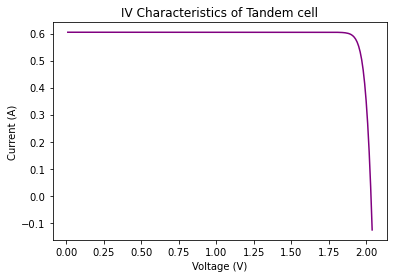

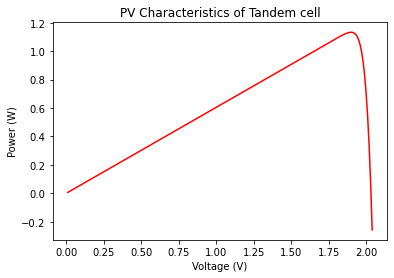

Maximum Power is 1.132666749340251 W
Efficeincy is 15.77352745465229 %


In [6]:
eg1=1.7
xp1=2e-6
xn1=1e-5
xp2=5e-5
xn2=3.26e-05

X=[eg1, xp1, xn1, xp2, xn2]

P, V, I=TanSim(X)

plt.plot(V, I, color='purple')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('IV Characteristics of Tandem cell')
plt.show()

plt.plot(V, P, color='red')
plt.xlabel('Voltage (V)')
plt.ylabel('Power (W)')
plt.title('PV Characteristics of Tandem cell')
plt.show()

print('Maximum Power is '+str(max(P))+' W')
print('Efficeincy is '+str(max(P)/s*1e4)+' %')

## <a name="PSO"></a> Particle Swarm Optimisation

The detail generic particle swarm optimisation algorithm can be found in [E].

### Particle Class

In PSO, each particle refers to a proposed solution $X$. In our case $X$ is an $R^5$ vector. Each particle class also holds the best value it had so far and also the corresponding best solution $pbest$. In addition it also holds I, V, P of its latest $X$.

### PSO Class

This class very convieniently uses the Particle Class. It holds an array of Particles, the global best solution $gbest$, and the corresponding best value so far. It also has tuning parameters $w, c_1, c_2$ and the limits on the values of $X$.

### The algorithm

1) Initialise the PSO class by generating $n$ Particles with random $X$'s.

2) Evaluate all particles. For each particle, compute the efficiency. If its better than the last best computed efficiency, update $pbest$ accordingly. Similarly update for global best $gbest$

3) Propagate each Particle. For each particle the new $X$ becomes

$X=wX+c_1r_1(pbest-X)+c_2r_2(gbest-X)$, where

$r_1, r_2$ are randomly generated numbers between $0$ and $1$.

Bound the new solution by limits.

In [7]:
class Particle(object):
    
    #Each Particle represents a solution
    def __init__(self, X, v=np.array([0, 0, 0, 0, 0])):
        
        self.X=X        #The solution
        self.P, self.V, self.I=TanSim(X)  #Corresponding P, V, I
        self.pbest=X        #The best solution so far
        self.pbestval=1e-15  #The best solution value so far
        
    def evaluate(self):
        
        #Find max P
        return max(self.P)
    
    def η(self):
        
        #Find the efficieny
        return max(self.P)/s*1e4

    

class PSO(object):
     
    #The particle swarm optimisation class
    def __init__(self):
        
        self.Particles=[]     #Ordered List of Particles
        self.gbest=[]         #Best solution so far
        self.gbestval=0       #Best value so far
        
        #Tuning coefficients
        self.c1=2
        self.c2=2
        self.w=0.5
        
        #Limits on solution values
        self.Egu=2.5
        self.Egl=1.1
        
        self.xp1l=0.1e-6
        self.xp1u=2e-6 * 10
        
        self.xn1l=1e-6
        self.xn1u=3e-6 * 10
        
        self.xp2l=1e-6
        self.xp2u=1e-6 * 100
        
        self.xn2l=1e-6
        self.xn2u=1e-6 * 100

        
    def ProduceParticle(self):
        
        #Generate a particle
        Y=np.random.rand(5)
        
        Eg = self.Egl + Y[0] * (self.Egu-self.Egl)
        xp1  = self.xp1l  + Y[1] * (self.xp1u-self.xp1l)
        xn1  = self.xn1l  + Y[2] * (self.xn1u-self.xn1l)
        xp2  = self.xp2l  + Y[3] * (self.xp2u-self.xp2l)
        xn2  = self.xn2l  + Y[4] * (self.xn2u-self.xn2l)
        
        X=np.array([Eg, xp1, xn1, xp2, xn2])

        return Particle(X)
    
    
    def initialise(self, n, limit=20):
        
        #Initialising n particles each with η > limit
        
        self.Particles=[]
        
        while len(self.Particles)<n:
            
            a=self.ProduceParticle()
            
            if a.η() > limit:
                
                self.Particles.append(a)
                
                #Also accordingly assign the gbest and gbestval
                if a.η() > self.gbestval:
                    self.gbestval=a.η()
                    self.gbest=a.X
                
                
                
    def evaluate(self):
        
        #Evalute all solutions
        
        for i in range(len(self.Particles)):
            
            η=self.Particles[i].η()    #Efficiency of ith particle
            
            if η > self.gbestval:
                
                #efficiency of this particle is best so far
                self.gbest=self.Particles[i].X
                self.gbestval=η
                self.Particles[i].pbestval=η
        
        
            elif η > self.Particles[i].pbestval:
                
                #efficiency of this cell is not global best, but its personal best
                self.Particles[i].pbestval=η
                self.Particles[i].pbest=self.Particles[i].X
                
                
    def propagate(self):
        
        for i in range(len(self.Particles)):
            
            X=self.Particles[i].X
            
            #update the X value of ith particle
            r=np.random.rand(2)
            X=self.w*X+self.c1*r[0]*(self.Particles[i].pbest-X)+self.c2*r[1]*(self.gbest-X)
            
            #Check limits
            
            if X[0]>self.Egu:
                X[0]=self.Egu
                
            if X[0]<self.Egl:
                X[0]=self.Egl
              
            
                
            if X[1]>self.xp1u:
                X[1]=self.xp1u
                
            if X[1]<self.xp1l:
                X[1]=self.xp1l
                
                
                
            if X[2]>self.xn1u:
                X[2]=self.xn1u
                
            if X[2]<self.xn1l:
                X[2]=self.xn1l
                
                
                
            if X[3]>self.xp2u:
                X[3]=self.xp2u
                
            if X[3]<self.xp2l:
                X[3]=self.xp2l
                
                
                
            if X[4]>self.xn2u:
                X[4]=self.xn2u
                
            if X[4]<self.xn2l:
                X[4]=self.xn2l
                
            
            #Update the value
            self.Particles[i].X=X

#### PSO in action

Now lets run the PSO 20 times, with 50 particles, and keep updating the solution 50 times. We shall accept a solution if its efficiency is greater than $25%$

In [8]:
Solutions=[]
SolVals=[]
while len(Solutions)<10:
    
    M=PSO()
    M.initialise(50, 5)

    for i in range(50):

        M.evaluate()
        M.propagate()
        
    if M.gbestval > 25:

        Solutions.append(M.gbest)
        SolVals.append(M.gbestval)

In [9]:
A=Solutions[SolVals.index(max(SolVals))]
print("The optimum Parameters are as follows:")
print()
print("Bandgap : "+str(A[0])+"eV")
print("Width p-InGaN : "+str(A[1])+"m")
print("Width n-InGaN : "+str(A[2])+"m")
print("Width p-Si : "+str(A[3])+"m")
print("Width n-Si : "+str(A[4])+"m")
print()
print('The corresponding maximum η is '+str(max(SolVals)))

The optimum Parameters are as follows:

Bandgap : 1.7866415583147894eV
Width p-InGaN : 3.283967193393693e-07m
Width n-InGaN : 1.572401491054875e-05m
Width p-Si : 6.185795900101203e-05m
Width n-Si : 8.919729810434231e-05m

The corresponding maximum η is 39.43800947427211


## <a name="Challenges"></a> Challenges

Reference [F] talks in detail about the challenges with InGAN

InGaN has some merits like Direct Bandgap, High absorption coefficient and excellent irradiance resistance, its practical use has been limited due to following factors:

1. For optimal performances, we need In content much greater than 20%. At such In content and required thicknesses, problems of phase segregation and In fluctuations occur. Basically some local sights have different In concentrations which leads to some places with not so optimal bandgaps leading to increase recombination centers and thus lower short circuit current than predicted.

2. Growing InGaN is also a challenge. Large interatomic spacing between InN and gaN results in solid phase miscibility gap. High vapur pressure of GaN leads to low In concentration.

3. p-InGaN is doped with Mg. It degrades the overall quality of crystal due to deffects and has higher series resistance. Also making low resistance Ohmic contact with p-InGaN is difficult as metals that do so are not readily available.

[G] has suggested the use of an nano structure interface layer with Si made with AlN or SiO2 or Si3N4. Simulation results in the same showed improvement in short circuit currents.

## <a name="Concentrators"></a> Use of Concentrators

Acccording to reference [B], the peak efficiency change has logarithmic dependance upon concentration of solar power. So we verify that.
The above simulations were performed again but with concentrated irradiation, that is $I_0$ was increased by a factor $X$. The optimal efficiencies thus obtained were as follows.

| $X$   | $\eta$ (%)     |
|-----|---------|
| 1   | 39.964 |
| 2   | 39.464 |
| 4   | 40.58 |
| 5  | 41.45 |
| 8  | 41.355 |
| 10  | 41.689 |
| 15 | 43.296 |
| 20   | 42.885 |
| 25   | 43.527 |
| 35   | 43.827 |
| 45  | 43.236 |
| 55  | 43.652 |
| 65  | 43.267 |
| 75 | 44.53 |
| 85  | 44.29 |
| 95  | 44.557 |
| 105 | 44.7 |

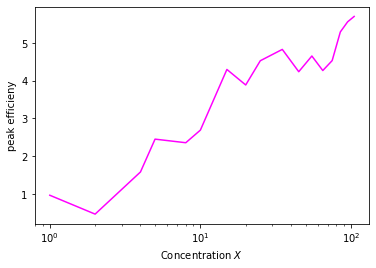

In [26]:
X=np.array([1, 2, 4, 5, 8, 10, 15, 20, 25, 35, 45, 55, 65, 75, 85, 95, 105])
Y=np.array([39.964, 39.464, 40.58, 41.45, 41.355, 41.689, 43.296, 42.885, 43.527, 43.827, 43.236, 43.652, 43.267, 43.53, 44.29, 44.557, 44.7])
Y=Y-39
plt.xscale('log')
plt.plot(X, Y, color='magenta')
plt.xlabel('Concentration $X$')
plt.ylabel('peak efficieny')
plt.show()

The above plot is logarithmic. Since, PSO is stochastic, we dont see a smooth curve, but we can still infer and conclude that change in peak effeciency is proportional to logarithm of concentration X

## <a name="References"></a> References

[A]  L. Hsu and W. Walukiewicz
, "Modeling of InGaN/Si tandem solar cells" , Journal of Applied Physics 104, 024507 (2008) https://doi.org/10.1063/1.2952031 

[B] M. E. Nell and A. M. Barnett, "The spectral p-n junction model for tandem solar-cell design," in IEEE Transactions on Electron Devices, vol. 34, no. 2, pp. 257-266, Feb. 1987, doi: 10.1109/T-ED.1987.22916.

[C] D. Benmoussa, H. Khachab and H. Benslimane, "Simulation of the Indium Gallium Nitride Multijunction Solar Cell Performances," 2017 International Renewable and Sustainable Energy Conference (IRSEC), Tangier, Morocco, 2017, pp. 1-5, doi: 10.1109/IRSEC.2017.8477398.

[D] Nacer, S., Aissat, A. Simulation and optimization of current matching double-junction InGaN/Si solar cells. Appl. Phys. A 122, 138 (2016). https://doi.org/10.1007/s00339-016-9677-7

[E] J. Kennedy and R. Eberhart, "Particle swarm optimization," Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4, doi: 10.1109/ICNN.1995.488968.

[F] A. G. Bhuiyan, K. Sugita, A. Hashimoto and A. Yamamoto, "InGaN Solar Cells: Present State of the Art and Important Challenges," in IEEE Journal of Photovoltaics, vol. 2, no. 3, pp. 276-293, July 2012, doi: 10.1109/JPHOTOV.2012.2193384.

[G] Ghosh, Bablu & ZAINAL, SSM & Saad, Ismail. (2014). Exploration of Interface Layer Aptness on Efficiency Aspect of InGaN/Si Double Junction Tandem Solar Cell. 